In [9]:
%matplotlib inline
%load_ext rpy2.ipython
import pandas as pd
import ggplot

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
def split_name(d):
    d = d.copy()
    d1 = d.name.str.extract(r'/(\d.+)\.(\d+)', expand=True)
    d2 = d1[0].str.split('_', expand=True)
    d['uid'] = d1[1]
    cols = ('coverage', 'universal_efficacy', 'seasonal_efficacy', 'proportion_universal')
    for i,c in zip(range(4), cols):
        d[c] = d2[i].astype(float)
    del d['name']
    return d 

def summarize(d):
    
    def summarize_by_age(d):
        return pd.Series({
            'individuals': d.N_p.mean(),
            'vaccines': d.V_i.sum(),
            'infections': d.IS_i.sum()
        })

    d1 = split_name(d).groupby(
        ['uid','age','coverage', 'universal_efficacy', 'seasonal_efficacy', 'proportion_universal']
    ).apply(summarize_by_age).reset_index()
    
    def summarize_by_uid(d):
        return pd.Series({
            'individuals': d.individuals.sum(),
            'vaccines': d.vaccines.sum(),
            'infections': d.infections.sum()
        })
    
    d2 = d1.groupby(['uid','coverage', 'universal_efficacy', 'seasonal_efficacy', 'proportion_universal']
                   ).apply(summarize_by_uid).reset_index()
    
    return d2

In [3]:
d = summarize(pd.read_csv('poe_output.csv'))

In [4]:
d.head()

,uid,coverage,universal_efficacy,seasonal_efficacy,proportion_universal,individuals,infections,vaccines
0,1206560604410060258,0.6,0.5,0.5,0.0,1188112.0,14327.0,2090548.0
1,1245767464275607353,0.5,0.3,0.4,0.0,1188112.0,60935.0,1782227.0
2,1296461284803586959,0.4,0.5,0.3,0.0,1188112.0,198510.0,1425780.0
3,1307201085673709560,0.6,0.5,0.3,0.0,1188112.0,6097.0,2090599.0
4,1326975095986561849,0.4,0.4,0.3,1.0,1188112.0,258819.0,1425780.0


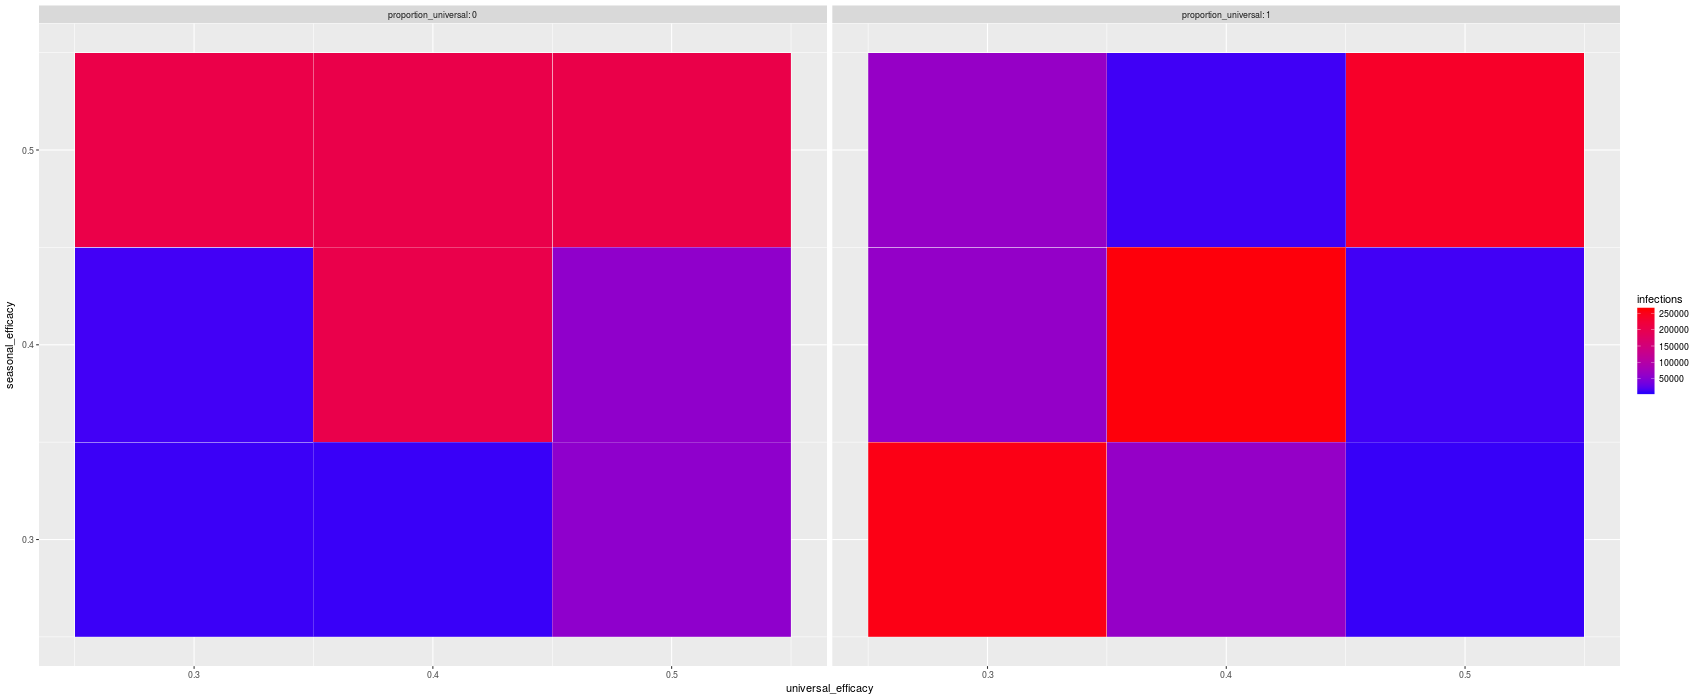

In [5]:
%%R -i d -w 1700 -h 700 -u px
library(pacman)
p_load(data.table,ggplot2,magrittr)


d = data.table(d)
d = d[,lapply(.SD, mean),by=c('coverage', 'universal_efficacy', 'seasonal_efficacy', 'proportion_universal'),.SDcols=c('individuals','infections','vaccines')]

years = 3
universal_cost_multiplier = 1
population_size = d$individuals %>% mean
baseline_infections = d[coverage==0.5 & proportion_universal==0.0]$infections %>% mean

#print(d %>% head)

ggplot(d, aes(universal_efficacy, seasonal_efficacy)) +
    geom_tile(aes(fill=infections), color='white') +
    scale_fill_gradient(low='blue',high='red') +
    facet_grid(. ~ proportion_universal, labeller = label_both) 

In [6]:
d2 = split_name(pd.read_csv('poe_output.csv'))

In [7]:
%%R -i d2 -w 1700 -h 700 -u px
library(pacman)
p_load(data.table,ggplot2,magrittr,Hmisc)
d2 = data.table(d2)

In [8]:
%%R -w 1700 -h 700 -u px
d = d2
d[,week:=day%/%7]
d = d[,.(I=sum(IS_i),N=sum(N_p)),by=.(uid,day,week,coverage,universal_efficacy,seasonal_efficacy,proportion_universal)]
d = d[,.(I=sum(I),N=mean(N)),by=.(uid,week,coverage,universal_efficacy,seasonal_efficacy,proportion_universal)]

In [9]:
%%R -w 900 -h 800 -u px
ggplot(d[seasonal_efficacy==0.5 & universal_efficacy==0.15 & coverage==0.3], aes(x=week*7,y=I/7)) +
    stat_summary(fun.data='mean_cl_boot', alpha=0.5, fill='steelblue', color='steelblue', geom='ribbon') +
    stat_summary(fun.y='mean', alpha=0.75, color='steelblue', geom='line', linetype='dashed') +
    facet_wrap(~ proportion_universal, ncol=1, labeller=label_both, scales='free') +
    xlab('Day') + ylab('Incidence of Symptomatic Infections') +
    theme(strip.background = element_rect(fill='white'))

/home/depasse/.conda/envs/phil/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: Faceting variables must have at least one value

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error: Faceting variables must have at least one value


In [11]:
def summarize2(d):
    
    def summarize_by_age(d):
        return pd.Series({
            'individuals': d.N_p.mean(),
            'vaccines': d.V_i.sum(),
            'infections': d.IS_i.sum()
        })

    d1 = split_name(d)
    d1['year'] = (d1.day / 360).astype('int')
    
    d1 = d1.groupby(
        ['uid','year', 'age','coverage', 'universal_efficacy', 'seasonal_efficacy', 'proportion_universal']
    ).apply(summarize_by_age).reset_index()
    
    d1 = d1.groupby(['year', 'age','coverage', 'universal_efficacy',
           'seasonal_efficacy', 'proportion_universal'], as_index=False).mean()
    #d1['age_specific_coverage'] = d1['vaccines'] / d1['individuals']
    d1['attack_rate'] = d1['infections'] / d1['individuals']
    return d1

In [12]:
d = summarize2(pd.read_csv('poe_output.csv'))

In [7]:
d.year.max()

3

In [13]:
d.to_csv('initial-results.csv', index=False)

In [17]:
pd.read_csv('poe_output.csv').day.max()

1044